# Código para Radar Coverage con DEM

* Trabajo con tensores 3D y una asignanción tipo bandera (flag) de conformación del terreno.

* Aún no tiene en cuenta la curvatura de la tierra.

## Librerias

In [248]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import rasterio
from scipy.interpolate import griddata


## Cargar el DEM para determinar una altura de radar

In [249]:
# Cargar el DEM
dem_path = "./ASTGTMV003_N06W076_dem.tif"

with rasterio.open(dem_path) as src:
    dem = src.read(1)  # banda 1 = elevación
    dem_transform = src.transform
    dem_crs = src.crs
    dem_height, dem_width = dem.shape

print("DEM cargado:", dem.shape, "CRS:", dem_crs)

DEM cargado: (3601, 3601) CRS: EPSG:4326


## Generación de radar en coordenadas geográficas y mediante cuadrículas de subdivisión

In [250]:
# Ubicación del radar
radar_lon = -75.68  # longitud del radar
radar_lat = 6.5    # latitud del radar

with rasterio.open(dem_path) as src:
    radar_elev = list(src.sample([(radar_lon, radar_lat)]))[0][0]

print("Altura terreno bajo radar:", radar_elev)
pedestal = 0.0  # metros encima del suelo
radar_alt = radar_elev + pedestal
# radar_alt = 400.0  # altura absoluta del radar (m.s.n.m)
print("Altura absoluta del radar:", radar_alt)

# Parámetros del radar
Pt = 50e3               # 50 kW
G = 10                  # ganancia
f = 1e9                 # 1 GHz
lam = 0.3               # longitud de onda
sigma = 10              # RCS = 10 m^2
SNR_min_dB = 20         # dB
SNR_min = 10**(SNR_min_dB/10)

k = 1.380649e-23        # constante de Boltzmann
T0 = 290                # K
Bn = 1e6                # ejemplo típico de 1 MHz de BW
Fn = 3                  # ruido (factor típico)
Simin = k * T0 * Bn * Fn * SNR_min

# Cálculo del Rmax
Rmax = ((Pt * (G**2) * lam**2 * sigma) / ((4*np.pi)**2 * Simin))**0.25
print("Rmax =", Rmax/1000, "km")

Altura terreno bajo radar: 1870
Altura absoluta del radar: 1870.0
Rmax = 12.41073671916898 km


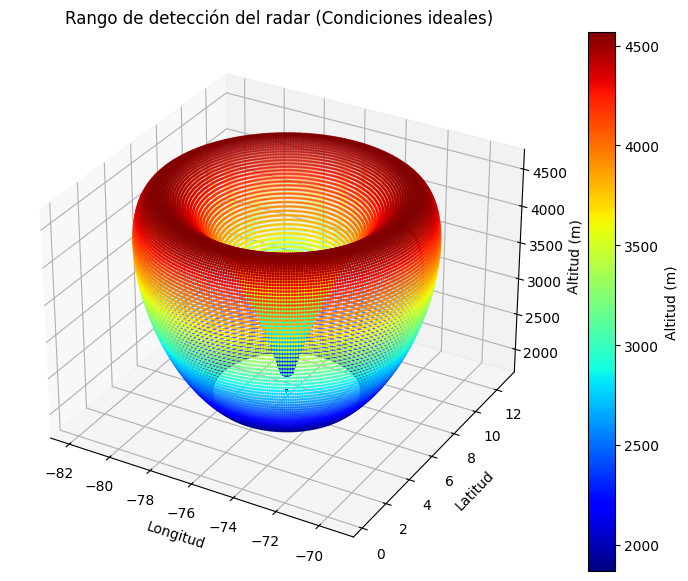

In [251]:
# Patrón de antena (modelo gaussiano)
theta0_5 = np.deg2rad(20)      # half-power beamwidth
theta_c  = np.deg2rad(10)      # eje del haz (ajústalo entre 20–30°) Para "gota"

def F(theta):
    return np.exp(-2.8 * (theta - theta_c)**2 / theta0_5**2) #Eq 14 con ligero ajuste centrado en un ángulo theta_c

# Para la elevación centramos el rango alrededor de theta_c
theta_min = 0.0
theta_max = np.deg2rad(45)     # rango útil de elevaciones
theta = np.linspace(theta_min, theta_max, 200) # elevaciones
phi   = np.linspace(0, 2*np.pi, 360) # azimutal completo

THETA, PHI = np.meshgrid(theta, phi)

F_val = F(THETA)

# Opcional: recortar lóbulos muy débiles
F_val[F_val < 0.04] = 0.0

R = Rmax * F_val # Eq. 13

# Conversión a coordenadas 3D locales
x = R * np.cos(THETA) * np.cos(PHI)
y = R * np.cos(THETA) * np.sin(PHI)
z = R * np.sin(THETA)

# Conversión coordenadas geográficas (lat, lon)
lat0 = np.deg2rad(radar_lat)  # Ingreso del dato: latitud del radar
lon0 = np.deg2rad(radar_lon) # Ingreso del dato: longitud del radar

# factores de conversión aproximados
meters_per_deg_lat = 111320
meters_per_deg_lon = 111320 * np.cos(lat0)

LAT = lat0 + (y / meters_per_deg_lat)
LON = lon0 + (x / meters_per_deg_lon)
ALT = z + radar_alt  # Ingreso del dato: altitud del radar en metros

LAT_deg = np.rad2deg(LAT)
LON_deg = np.rad2deg(LON)

# Visualización 3D
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')

p = ax.scatter(LON_deg, LAT_deg, ALT, c=ALT, cmap='jet', s=1)

ax.set_xlabel("Longitud")
ax.set_ylabel("Latitud")
ax.set_zlabel("Altitud (m)")
ax.set_title("Rango de detección del radar (Condiciones ideales)")

plt.colorbar(p, label="Altitud (m)")
plt.show()

Detallar el recorte vertical del area de covertura ideal del radar

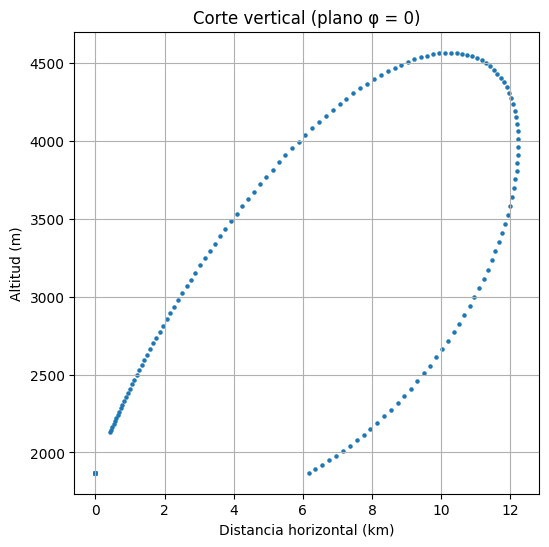

In [252]:
# Tomar un azimut fijo (por ejemplo phi = 0)
idx_phi0 = 0 # dirección este (east)
x_slice = x[idx_phi0, :]
z_slice = ALT[idx_phi0, :]  # ya con 400 m sumados

plt.figure(figsize=(6,6))
plt.scatter(x_slice/1000, z_slice, s=5) # Convertir x a km
plt.xlabel("Distancia horizontal (km)")
plt.ylabel("Altitud (m)")
plt.title("Corte vertical (plano φ = 0)")
plt.grid(True)
plt.show()

Ahora haremos los voxeles o cuadriculas de division del radar usando una metodología parecida a GeoSOT-3D o divsiones cubicas regulares

Layer 18; grid size = 160.0 m
Bounding box (m):
x: -12320.0 ; 12320.0
y: -12320.0 ; 12320.0
z: 0.0 ; 2720.0
Grid shape: 154 , 154 , 17
Número de voxeles con radar ideal: 29507


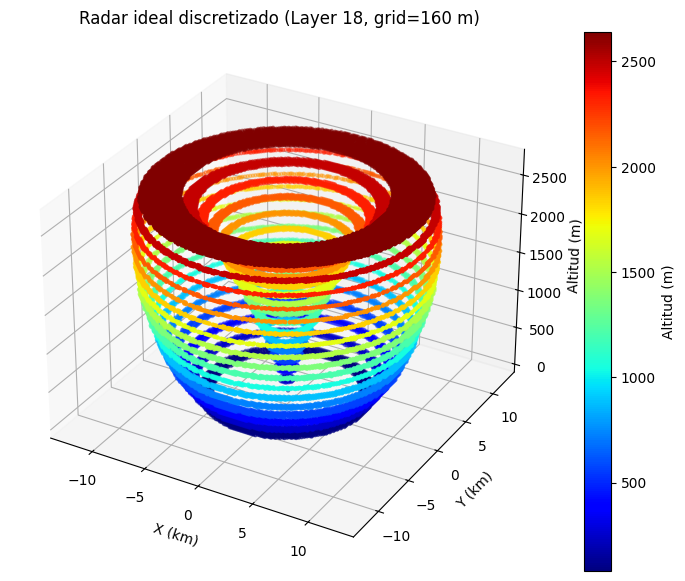

In [253]:
#Elegir Layer tipo GeoSOT-3D

layer = 18  # se puede cambiar según la tabla del paper
grid_size = 1280.0 / 2**(layer - 15)   # m, Tabla 4 del paper
print(f"Layer {layer}; grid size = {grid_size} m")

# Bounding box del radar en coords locales (x,y,z)

# aplanar por si x,y,z vienen en malla (phi, theta)
x_flat = x.ravel()
y_flat = y.ravel()
z_flat = z.ravel()

# opcional: quedarnos solo con puntos donde hay rango distinto de cero
mask_valid = ~np.isnan(x_flat)  # Se puede reemplazar con cualquier otra condición de validez
x_flat = x_flat[mask_valid]
y_flat = y_flat[mask_valid]
z_flat = z_flat[mask_valid]

# límites de la malla, redondeados a múltiplos de grid_size
def pad_to_grid(min_val, max_val, gs):
    min_g = np.floor(min_val / gs) * gs
    max_g = np.ceil(max_val / gs) * gs
    return min_g, max_g

# calcular bounding box en metros
xmin, xmax = pad_to_grid(x_flat.min(), x_flat.max(), grid_size)
ymin, ymax = pad_to_grid(y_flat.min(), y_flat.max(), grid_size)
zmin, zmax = pad_to_grid(z_flat.min(), z_flat.max(), grid_size)

print("Bounding box (m):")
print("x:", xmin, ";",xmax)
print("y:", ymin, ";", ymax)
print("z:", zmin, ";", zmax)

# número de voxeles por eje
nx = int((xmax - xmin) / grid_size)
ny = int((ymax - ymin) / grid_size)
nz = int((zmax - zmin) / grid_size)
print("Grid shape:", nx, ",", ny, ",", nz)

# CREAR TENSOR 3D de type flags
#    0 es no calculado
#    1 es radar real 
#    2 es boundary ideal radar 
#    3 es terreno

grid_flags = np.zeros((nx, ny, nz), dtype=np.uint8)

# Mapear cada punto del radar a un voxel (i,j,k)

# índices de voxel
ix = ((x_flat - xmin) / grid_size).astype(int)
iy = ((y_flat - ymin) / grid_size).astype(int)
iz = ((z_flat - zmin) / grid_size).astype(int)

# asegurarnos de que están en rango
valid = (ix >= 0) & (ix < nx) & (iy >= 0) & (iy < ny) & (iz >= 0) & (iz < nz) # Condición de validez puros and (&) y operadores lógicos
ix, iy, iz = ix[valid], iy[valid], iz[valid]

# ponemos flag=2 en todas las celdas por donde pasa el radar ideal
grid_flags[ix, iy, iz] = 2

# obtener las coordenadas de los centros de voxeles "radar"

# construir arrays de coordenadas de centros
xc = xmin + (np.arange(nx) + 0.5) * grid_size
yc = ymin + (np.arange(ny) + 0.5) * grid_size
zc = zmin + (np.arange(nz) + 0.5) * grid_size

# obtener índices de voxeles con flag=2
IX, IY, IZ = np.where(grid_flags == 2)
Xc = xc[IX]
Yc = yc[IY]
Zc = zc[IZ]

print("Número de voxeles con radar ideal:", len(Xc))

# 6. Visualizar la versión voxelizada del radar ideal - equivalente a Fig. 13(b) del paper pero en coords locales
fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(111, projection='3d')

p = ax.scatter(Xc/1000.0, Yc/1000.0, Zc, s=5, c=Zc, cmap='jet')

ax.set_xlabel("X (km)")
ax.set_ylabel("Y (km)")
ax.set_zlabel("Altitud (m)")
ax.set_title(f"Radar ideal discretizado (Layer {layer}, grid={grid_size:.0f} m)")

plt.colorbar(p, label="Altitud (m)")
plt.show()

# La visualización es con puntos en lugar de cubos, pero eso se puede cambiar luego ya que es algo meramente visual

Prueba de graficas con cubos

Recomendación: Si se va a usar la siguiente forma de graficar, no usar un layer muy alto (18,19) o se puede demorar varios minutos en correr

In [254]:
# grid_flags: tensor 3D con flags (0=vacío, 2=radar ideal, etc.)
# filled = (grid_flags == 2)   # True donde hay radar ideal

# fig = plt.figure(figsize=(9,7))
# ax = fig.add_subplot(111, projection='3d')

# # Voxeles en coordenadas de índice: 0..nx-1, etc.
# # ax.voxels coloca un cubo en cada (i,j,k) donde filled[i,j,k] es True
# ax.voxels(
#     filled,
#     facecolors='cyan',     # color sólido tipo paper
#     edgecolor='k',         # bordes negros finos
# )

# ax.set_xlabel("Longitude index")
# ax.set_ylabel("Latitude index")
# ax.set_zlabel("Altitude index")
# ax.set_title("Radar ideal discretizado (índices de grilla)")

# plt.show()

## Carga del DEM, creación del Sterrain y visualización 3D

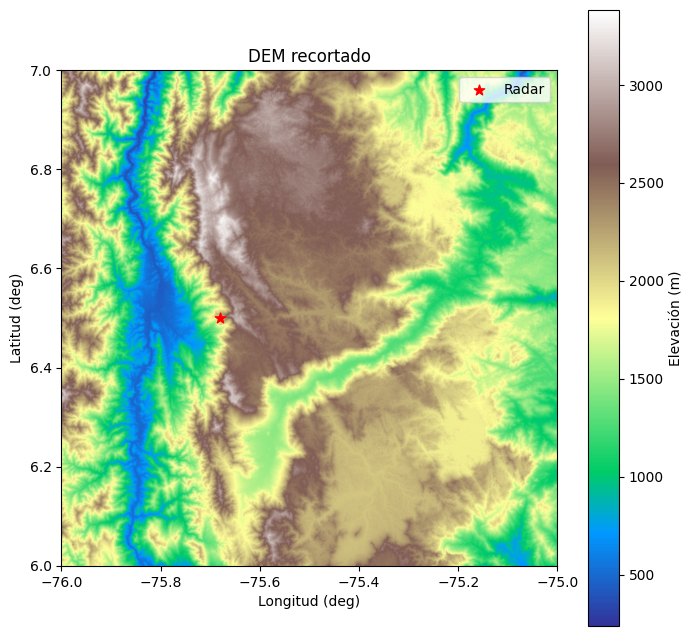

In [ ]:
# Graficar el DEM 
dem_plot = dem.astype(float)
dem_plot[dem_plot == 0] = np.nan  # opcional: enmascarar nodata (0) para mejor visual

# calcular extent en grados: [left, right, bottom, top]
left = dem_transform.c
top = dem_transform.f
right = left + dem_transform.a * dem_width
bottom = top + dem_transform.e * dem_height
extent = [left, right, bottom, top]

plt.figure(figsize=(8,8))
im = plt.imshow(dem_plot, extent=extent, cmap='terrain', origin='upper')
plt.colorbar(im, label='Elevación (m)')
plt.xlabel('Longitud (deg)')
plt.ylabel('Latitud (deg)')
plt.title('Representación de DEM')

# marcar la posición del radar (lon0, lat0 están en radianes)
plt.scatter(radar_lon, radar_lat, c='red', s=60, marker='*', label='Radar')
plt.legend()
plt.show()

In [256]:
# VOXELIZAR EL DEM EN grid_flags

# Crear lon/lat 2D del DEM

# Obtener dimensiones
h, w = dem.shape
lon = np.zeros_like(dem, dtype=float)
lat = np.zeros_like(dem, dtype=float)

for i in range(h):
    lon_i, lat_i = rasterio.transform.xy(
        dem_transform,
        [i] * w,
        np.arange(w)
    )
    lon[i, :] = lon_i
    lat[i, :] = lat_i

# Convertir lon/lat a coords locales (x,y)
dx = (lon - radar_lon) * meters_per_deg_lon   # matriz 2D
dy = (lat - radar_lat) * meters_per_deg_lat   # matriz 2D

# Altura local del terreno respecto al radar
z_terrain_local = dem.astype(float) - radar_alt

# Filtrar nodata
mask_valid = (~np.isnan(z_terrain_local)) & (dem != 0) # matriz booleana 2D

dx_flat = dx[mask_valid]
dy_flat = dy[mask_valid]
z_flat = z_terrain_local[mask_valid]

Vamos a seguir con la identación a voxeles (Tensores)

In [257]:
# Convertir coords a índices de voxel
ix = ((dx_flat - xmin) / grid_size).astype(int)
iy = ((dy_flat - ymin) / grid_size).astype(int)
iz = ((z_flat - zmin) / grid_size).astype(int)

valid = (ix >= 0) & (ix < nx) & \
        (iy >= 0) & (iy < ny) & \
        (iz >= 0) & (iz < nz)

ix = ix[valid]
iy = iy[valid]
iz = iz[valid]

# Marcar terreno (flag = 3)
grid_flags[ix, iy, iz] = 3

print("Voxeles superficie:", len(ix))

# Rellenar terreno como sólido (opcional)
for i, j, k in zip(ix, iy, iz):
    grid_flags[i, j, :k+1] = 3

Voxeles superficie: 379698


Visualización del volúmen del terreno más el volumen del radar (No se usa la representación de voxel en cubos por temas computacionales).

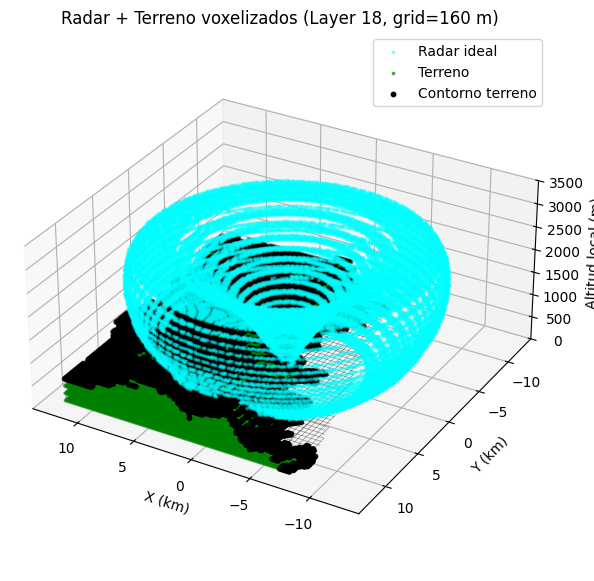

In [ ]:
# Visualización de radar (2) y terreno (3) juntos
IX_radar, IY_radar, IZ_radar = np.where(grid_flags == 2)
IX_terr,  IY_terr,  IZ_terr  = np.where(grid_flags == 3)

Xc_r = xc[IX_radar]
Yc_r = yc[IY_radar]
Zc_r = zc[IZ_radar]

Xc_t = xc[IX_terr]
Yc_t = yc[IY_terr]
Zc_t = zc[IZ_terr]

fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(111, projection='3d')

# Radar ideal en un color
ax.scatter(Xc_r/1000.0, Yc_r/1000.0, Zc_r, s=3, alpha=0.4, c="cyan", label='Radar ideal')

# Terreno en otro color
ax.scatter(Xc_t/1000.0, Yc_t/1000.0, Zc_t, s=3, alpha=0.6, c="green", label='Terreno')

# Contorno superior del terreno para mejor visualización
terrain_top = {}
for x, y, z in zip(Xc_t, Yc_t, Zc_t):
    key = (round(x, 2), round(y, 2))
    if key not in terrain_top or z > terrain_top[key]:
        terrain_top[key] = z

Xc_cont = np.array([k[0] for k in terrain_top.keys()]) # coordenadas X únicas centro del contorno
Yc_cont = np.array([k[1] for k in terrain_top.keys()]) # coordenadas Y únicas centro del contorno
Zc_cont = np.array(list(terrain_top.values())) # alturas del centro del contorno 

ax.scatter(Xc_cont/1000.0, Yc_cont/1000.0, Zc_cont, s=10, c='black', marker='o', label='Contorno terreno')

# Rejilla para wireframe - interpolación
xi = np.linspace(Xc_t.min(), Xc_t.max(), 100)
yi = np.linspace(Yc_t.min(), Yc_t.max(), 100)
Xi, Yi = np.meshgrid(xi, yi)

# Interpolación de alturas
Zi = griddata((Xc_t, Yc_t), Zc_t, (Xi, Yi), method='linear')

# Dibujar wireframe
ax.plot_wireframe(Xi/1000.0, Yi/1000.0, Zi, color='black', linewidth=0.4, alpha=0.5)

# Ajustar escala Z para que no se aplaste visualmente
ax.set_zlim(0, 3500)   
ax.set_box_aspect((1, 1, 0.5))   # comprime el eje Z a la mitad

ax.set_xlabel("X (km)")
ax.set_ylabel("Y (km)")
ax.set_zlabel("Altitud local (m)")
ax.set_title(f"Radar + Terreno voxelizados (Layer {layer}, grid={grid_size:.0f} m)")

#angulo de vista inicial
ax.view_init(elev=30, azim=120)

ax.legend()
plt.show()

## Obtener la frontera del radar ideal (S_boundary)

Voxeles en la frontera del radar ideal: 25772


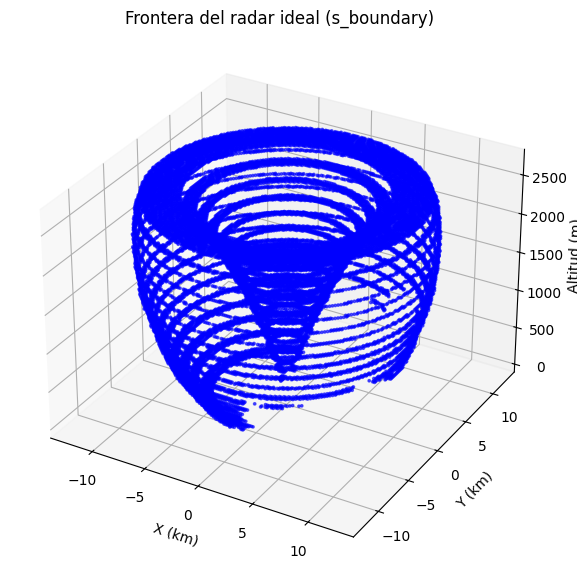

In [ ]:
# Extraer todos los voxeles con flag = 2 (radar ideal)
IX_r, IY_r, IZ_r = np.where(grid_flags == 2)

# Lista para guardar los voxeles que son frontera
boundary_list = []

# Desplazamientos para vecindad 26
neighbors = [(dx,dy,dz) 
             for dx in [-1,0,1]
             for dy in [-1,0,1]
             for dz in [-1,0,1]
             if not (dx==0 and dy==0 and dz==0)]

nx, ny, nz = grid_flags.shape

for x0, y0, z0 in zip(IX_r, IY_r, IZ_r):

    is_boundary = False

    for dx, dy, dz in neighbors:
        x1 = x0 + dx
        y1 = y0 + dy
        z1 = z0 + dz

        # Fuera de la malla = frontera automáticamente
        if x1 < 0 or x1 >= nx or y1 < 0 or y1 >= ny or z1 < 0 or z1 >= nz:
            is_boundary = True
            break

        # Si el vecino no es radar (2), entonces la celda sí es frontera
        if grid_flags[x1, y1, z1] != 2:
            is_boundary = True
            break

    if is_boundary:
        boundary_list.append((x0, y0, z0))

# Convertir a arrays
boundary_list = np.array(boundary_list)
print("Voxeles en la frontera del radar ideal:", len(boundary_list))

# Visualizar voxeles frontera
# Obtener coordenadas de los voxeles frontera
IX_b, IY_b, IZ_b = boundary_list[:,0], boundary_list[:,1], boundary_list[:,2]

Xb = xc[IX_b]
Yb = yc[IY_b]
Zb = zc[IZ_b]

fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(Xb/1000.0, Yb/1000.0, Zb, s=3, c='blue', alpha=0.6)

ax.set_xlabel("X (km)")
ax.set_ylabel("Y (km)")
ax.set_zlabel("Altitud (m)")
ax.set_title("Frontera del radar ideal (s_boundary)")
plt.show()

## Obtener S_RT, definir el elemento estructurante para la dilatación e inicializar los conjuntos necesarios

Elemento estructurante y S_RT

Vecinos en SE_3D: 26
Voxeles en S_RT: 1061


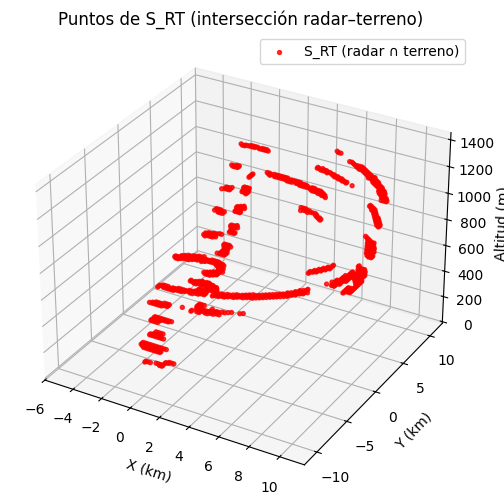

In [262]:
# Elemento estructurante 3D (SE 3D) (26 vecinos)

SE_3D = [(dx, dy, dz)
         for dx in [-1, 0, 1]
         for dy in [-1, 0, 1]
         for dz in [-1, 0, 1]
         if not (dx == 0 and dy == 0 and dz == 0)]

print("Vecinos en SE_3D:", len(SE_3D))  # debe ser 26

# S_RT = boundary ∩ vecinos que tocan terreno

S_RT_list = []

for x0, y0, z0 in boundary_list:
    is_intersecting = False
    for dx, dy, dz in SE_3D:   # 26 vecinos
        x1 = x0 + dx
        y1 = y0 + dy
        z1 = z0 + dz

        if x1 < 0 or x1 >= nx or y1 < 0 or y1 >= ny or z1 < 0 or z1 >= nz:
            continue

        if grid_flags[x1, y1, z1] == 3:   # terreno
            is_intersecting = True
            break

    if is_intersecting:
        S_RT_list.append((x0, y0, z0))

S_RT = np.array(S_RT_list)
print("Voxeles en S_RT:", len(S_RT)) 

# Visualizar S_RT

if len(S_RT) > 0:
    IX_rt, IY_rt, IZ_rt = S_RT[:,0], S_RT[:,1], S_RT[:,2]

    X_rt = xc[IX_rt]
    Y_rt = yc[IY_rt]
    Z_rt = zc[IZ_rt]

    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(X_rt/1000.0, Y_rt/1000.0, Z_rt,
               c='red', s=8, alpha=0.8, label='S_RT (radar ∩ terreno)')

    ax.set_xlabel("X (km)")
    ax.set_ylabel("Y (km)")
    ax.set_zlabel("Altitud (m)")
    ax.set_title("Puntos de S_RT (intersección radar–terreno)")
    ax.legend()

    plt.show()
else:
    print("S_RT está vacío.")

Inicialización de conjuntos necesarios y el número de iteraciones

In [263]:
# Inicialización del conjunto de dilatación S_d
S_d = {0: S_RT.copy()}

# S_TM = S_Terrain (máscara)
S_TM = (grid_flags == 3)

# Definir número de iteraciones n
n = 200  # Ajustable